Steady state positions: [ 0.67  1.   -0.33]
Steady state tensions: [-0.  2.]


/Users/giray98/load/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


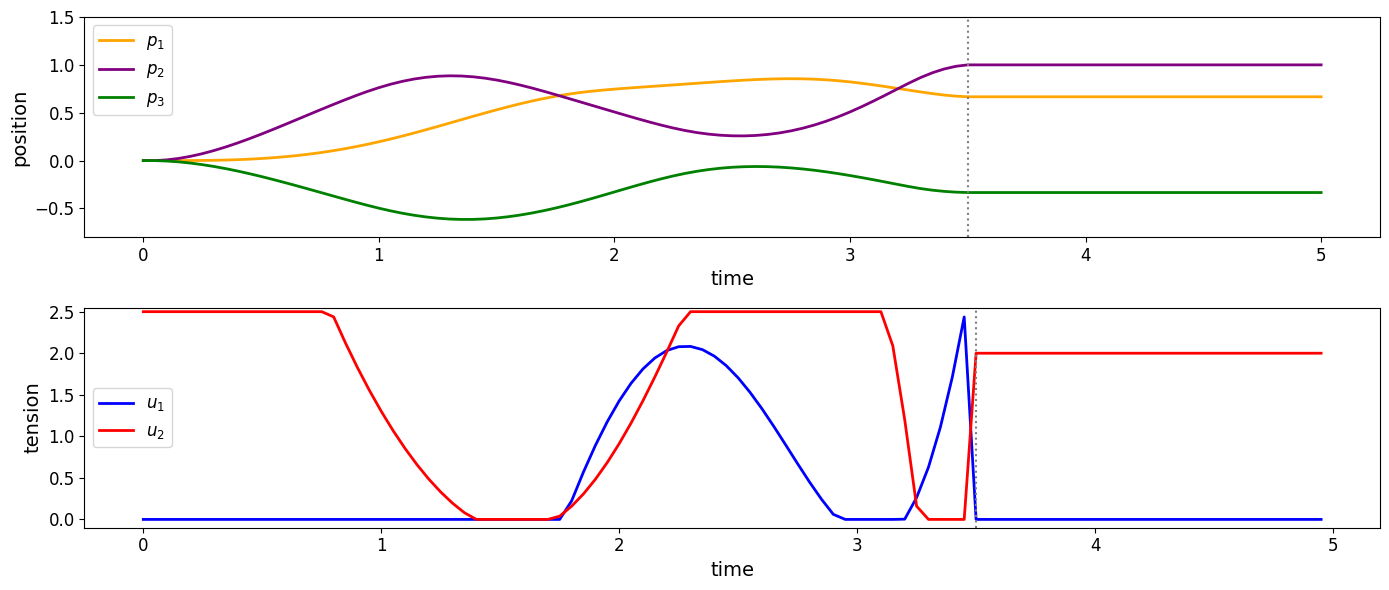

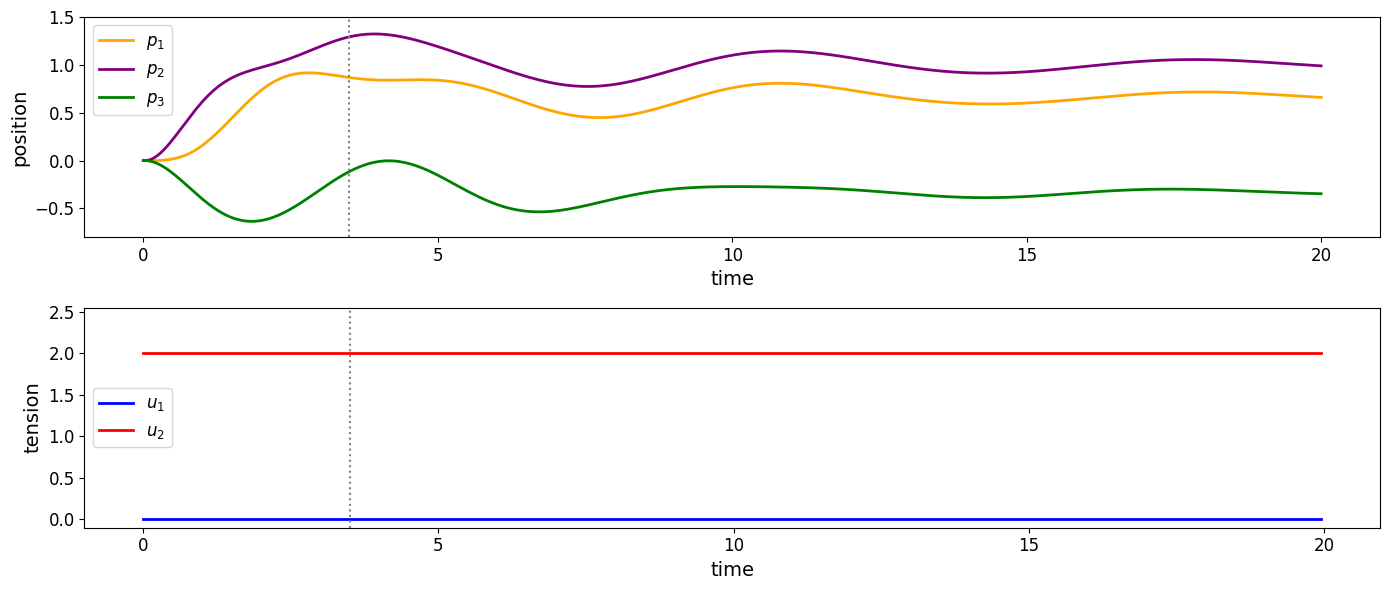

In [4]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# ----- SYSTEM PARAMETERS ------
T_total = 5 # Total time of simulation
T_ss = 3.5 # Targeted steady state time
h = 0.05 # Time step (50 ms)
N = int(T_total / h) # Number of time steps
N_ss = int(T_ss / h) # Number of time steps for steady state
p_des = 1.0 # Desired position at steady state for the second block
u_max = 2.5 # Maximum allowed tension
m1 = 1 # Mass of the first block (kg)
m2 = 0.8 # Mass of the second block (kg)
m3 = 1.4 # Mass of the third block (kg)
K = np.diag([1, 2, 1, 2]) # Spring constants (N/m) K = np.diag([k1, k2, k3, k4])
D = np.diag([0.5, 0.4, 0.5, 0.3]) # Damping constants (Ns/m) D = np.diag([d1, d2, d3, d4])
A = np.array([[1, -1, 0, 0], [0, 1, -1, 0],[0, 0, 1, -1]]) # Graph laplacian of the system
B = np.array([[1, 0], [-1, 1], [0, -1]]) # Input matrix

# ----- STEADY STATE PROBLEM ------
# First, we need to find the steady state values of the system
# to determine steady state positions and tensions for all blocks
F = np.linalg.inv(A@K@A.T)@B # At steady state, velocities and accelerations are zero
p_ss, u_ss = cp.Variable((3,)), cp.Variable((2,))
obj = cp.Minimize(cp.sum_squares(u_ss))
cons = [0 <= u_ss, u_ss <= u_max, p_ss[1] == p_des, p_ss == F@u_ss]
prob = cp.Problem(obj, cons)
prob.solve()
u_ss = u_ss.value
p_ss = p_ss.value
print(f"Steady state positions: {np.round(p_ss,2)}")
print(f"Steady state tensions: {np.round(u_ss,2)}")


# ----- OPTIMAL CONTROL VIA TENSIONS ------
M_inverse = np.diag([1/m1, 1/m2, 1/m3])
lambd = 1.0
p_des = np.tile(p_ss, (N+1, 1))
u_des = np.tile(u_ss, (N, 1))
p, v, u = cp.Variable((N+1, 3)), cp.Variable((N+1, 3)), cp.Variable((N, 2))
obj = cp.Minimize(cp.sum_squares(p - p_des) + cp.sum_squares(v)+ lambd * cp.sum_squares(u-u_des))
cons = [p[0]==0, v[0]==0, p[N_ss]==p_ss, v[N_ss] == 0, 0 <= u, u <= u_max]
cons+= [p[t+1] == p[t] + h*v[t] for t in range(N)]
cons+= [v[t+1] == v[t] + h*M_inverse@
        (-(A@K@A.T)@p[t]- (A@D@A.T)@v[t] + B@u[t]) for t in range(N)]
prob = cp.Problem(obj, cons)
prob.solve()
p = p.value
u = u.value
v = v.value

# ----- PLOTTING RESULTS OF OPTIMAL CONTROL VIA TENSIONS -----
t = np.linspace(0, T_total, N+1)
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(t, p[:,0], label=r'$p_1$', color='orange', linewidth=2)
plt.plot(t, p[:,1], label=r'$p_2$', color='purple', linewidth=2)
plt.plot(t, p[:,2], label=r'$p_3$', color='green', linewidth=2)
plt.xlabel('time', fontsize=14)
plt.ylabel('position', fontsize=14)
plt.axvline(x=3.5, linestyle=':', color='gray')
plt.legend(fontsize=12, loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(False)
plt.ylim(-0.8, 1.5)

plt.subplot(2, 1, 2)
plt.plot(t[:-1], u[:,0], label=r'$u_1$', color='blue', linewidth=2)
plt.plot(t[:-1], u[:,1], label=r'$u_2$', color='red', linewidth=2)
plt.xlabel('time', fontsize=14)
plt.ylabel('tension', fontsize=14)
plt.axvline(x=3.5, linestyle=':', color='gray')
plt.legend(fontsize=12, loc='center left')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(False)
plt.ylim(-0.1, 2.55)
plt.tight_layout()
plt.savefig('position_control.pdf')
plt.show()

# ----- OPTIMAL CONTROL VIA CONSTANT TENSIONS ------
# In this case, we assume that the tensions are constant and equal to the steady state values
T_total = 20 # Longer simulation time because it will take longer to settle down
N = int(T_total / h) # Number of time steps
p_des = np.tile(p_ss, (N+1, 1))
u_des = np.tile(u_ss, (N, 1))

p_cons, v_cons, u_cons = cp.Variable((N+1, 3)), cp.Variable((N+1, 3)), cp.Variable((N, 2))
obj = cp.Minimize(cp.sum_squares(p_cons - p_des) + cp.sum_squares(v_cons) + lambd * cp.sum_squares(u_cons-u_des))
cons = [p_cons[0]==np.zeros(3), v_cons[0]==np.zeros(3)]
cons+= [p_cons[t+1] == p_cons[t] + h*v_cons[t] for t in range(N)]
cons+= [v_cons[t+1] == v_cons[t] + h*M_inverse@(-(A@K@A.T)@p_cons[t]- (A@D@A.T)@v_cons[t] + B@u_cons[t]) for t in range(N)]
cons+= [u_cons[t] == u_ss for t in range(N)]
prob = cp.Problem(obj, cons)
prob.solve()
p_cons = p_cons.value
u_cons = u_cons.value
v_cons = v_cons.value


# ----- PLOTTING RESULTS OF OPTIMAL CONTROL VIA CONSTANT TENSIONS -----
t = np.linspace(0, T_total, N+1)
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(t, p_cons[:,0], label=r'$p_1$', color='orange', linewidth=2)
plt.plot(t, p_cons[:,1], label=r'$p_2$', color='purple', linewidth=2)
plt.plot(t, p_cons[:,2], label=r'$p_3$', color='green', linewidth=2)
plt.xlabel('time', fontsize=14)
plt.ylabel('position', fontsize=14)
plt.axvline(x=3.5, linestyle=':', color='gray')
plt.legend(fontsize=12, loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(False)
plt.ylim(-0.8, 1.5)
plt.xticks([0, 5, 10, 15, 20], [str(i) for i in [0, 5, 10, 15, 20]])

plt.subplot(2, 1, 2)
plt.plot(t[:-1], u_cons[:,0], label=r'$u_1$', color='blue', linewidth=2)
plt.plot(t[:-1], u_cons[:,1], label=r'$u_2$', color='red', linewidth=2)
plt.xlabel('time', fontsize=14)
plt.ylabel('tension', fontsize=14)
plt.axvline(x=3.5, linestyle=':', color='gray')
plt.legend(fontsize=12, loc='center left')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(False)
plt.ylim(-0.1, 2.55)
plt.xticks([0, 5, 10, 15, 20], [str(i) for i in [0, 5, 10, 15, 20]])
plt.tight_layout()
plt.savefig('position_control_constant.pdf')
plt.show()